In [ ]:
!python --version

In [1]:
!git clone https://github.com/davidADSP/GDL_code

Cloning into 'GDL_code'...
remote: Enumerating objects: 394, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 394 (delta 0), reused 1 (delta 0), pack-reused 391
Receiving objects: 100% (394/394), 22.13 MiB | 0 bytes/s, done.
Resolving deltas: 100% (237/237), done.


In [2]:
cd /kaggle/working/GDL_code

/kaggle/working/GDL_code


In [25]:
pip install gsutil 

     |████████████████████████████████| 3.0MB 3.8MB/s eta 0:00:01
     |████████████████████████████████| 51kB 6.0MB/s  eta 0:00:01
     |████████████████████████████████| 92kB 9.3MB/s  eta 0:00:01
     |████████████████████████████████| 143kB 32.7MB/s eta 0:00:01
     |████████████████████████████████| 102kB 10.9MB/s ta 0:00:01
     |████████████████████████████████| 184kB 48.2MB/s eta 0:00:01
     |████████████████████████████████| 102kB 10.5MB/s ta 0:00:01
     |████████████████████████████████| 993kB 30.5MB/s eta 0:00:01
     |████████████████████████████████| 276kB 26.3MB/s eta 0:00:01
     |████████████████████████████████| 163kB 28.6MB/s eta 0:00:01
     |████████████████████████████████| 194kB 47.7MB/s eta 0:00:01
     |████████████████████████████████| 163kB 33.5MB/s eta 0:00:01
  Created wheel for gsutil: filename=gsutil-5.27-cp36-none-any.whl size=3785289 sha256=afb56372e833254489bb7fb330d1ee96810498c76097a799969ab9ad050ca8e7
  Stored in directory: /root/.cache/pip/wheels/78

In [33]:
!gsutil -m cp -r "gs://quickdraw_dataset/full/numpy_bitmap/camel.npy" .

Copying gs://quickdraw_dataset/full/numpy_bitmap/camel.npy...
\ [1/1 files][ 90.8 MiB/ 90.8 MiB] 100% Done                                    
Operation completed over 1 objects/90.8 MiB.                                     


In [3]:
!mkdir gan

In [4]:
cd gan

/kaggle/working/GDL_code/gan


In [5]:

from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D
from keras.layers.merge import _Merge

from keras.models import Model, Sequential
from keras import backend as K
from keras.optimizers import Adam, RMSprop
from keras.utils import plot_model
from keras.initializers import RandomNormal

import numpy as np
import json
import os
import pickle as pkl
import matplotlib.pyplot as plt


class GAN():
    def __init__(self
        , input_dim
        , discriminator_conv_filters
        , discriminator_conv_kernel_size
        , discriminator_conv_strides
        , discriminator_batch_norm_momentum
        , discriminator_activation
        , discriminator_dropout_rate
        , discriminator_learning_rate
        , generator_initial_dense_layer_size
        , generator_upsample
        , generator_conv_filters
        , generator_conv_kernel_size
        , generator_conv_strides
        , generator_batch_norm_momentum
        , generator_activation
        , generator_dropout_rate
        , generator_learning_rate
        , optimiser
        , z_dim
        ):

        self.name = 'gan'

        self.input_dim = input_dim
        self.discriminator_conv_filters = discriminator_conv_filters
        self.discriminator_conv_kernel_size = discriminator_conv_kernel_size
        self.discriminator_conv_strides = discriminator_conv_strides
        self.discriminator_batch_norm_momentum = discriminator_batch_norm_momentum
        self.discriminator_activation = discriminator_activation
        self.discriminator_dropout_rate = discriminator_dropout_rate
        self.discriminator_learning_rate = discriminator_learning_rate

        self.generator_initial_dense_layer_size = generator_initial_dense_layer_size
        self.generator_upsample = generator_upsample
        self.generator_conv_filters = generator_conv_filters
        self.generator_conv_kernel_size = generator_conv_kernel_size
        self.generator_conv_strides = generator_conv_strides
        self.generator_batch_norm_momentum = generator_batch_norm_momentum
        self.generator_activation = generator_activation
        self.generator_dropout_rate = generator_dropout_rate
        self.generator_learning_rate = generator_learning_rate
        
        self.optimiser = optimiser
        self.z_dim = z_dim

        self.n_layers_discriminator = len(discriminator_conv_filters)
        self.n_layers_generator = len(generator_conv_filters)

        self.weight_init = RandomNormal(mean=0., stddev=0.02)

        self.d_losses = []
        self.g_losses = []

        self.epoch = 0

        self._build_discriminator()
        self._build_generator()

        self._build_adversarial()

    def get_activation(self, activation):
        if activation == 'leaky_relu':
            layer = LeakyReLU(alpha = 0.2)
        else:
            layer = Activation(activation)
        return layer

    def _build_discriminator(self):

        ### THE discriminator
        discriminator_input = Input(shape=self.input_dim, name='discriminator_input')

        x = discriminator_input

        for i in range(self.n_layers_discriminator):

            x = Conv2D(
                filters = self.discriminator_conv_filters[i]
                , kernel_size = self.discriminator_conv_kernel_size[i]
                , strides = self.discriminator_conv_strides[i]
                , padding = 'same'
                , name = 'discriminator_conv_' + str(i)
                , kernel_initializer = self.weight_init
                )(x)

            if self.discriminator_batch_norm_momentum and i > 0:
                x = BatchNormalization(momentum = self.discriminator_batch_norm_momentum)(x)

            x = self.get_activation(self.discriminator_activation)(x)

            if self.discriminator_dropout_rate:
                x = Dropout(rate = self.discriminator_dropout_rate)(x)

        x = Flatten()(x)
        
        discriminator_output = Dense(1, activation='sigmoid', kernel_initializer = self.weight_init)(x)

        self.discriminator = Model(discriminator_input, discriminator_output)


    def _build_generator(self):

        ### THE generator

        generator_input = Input(shape=(self.z_dim,), name='generator_input')

        x = generator_input

        x = Dense(np.prod(self.generator_initial_dense_layer_size), kernel_initializer = self.weight_init)(x)

        if self.generator_batch_norm_momentum:
            x = BatchNormalization(momentum = self.generator_batch_norm_momentum)(x)

        x = self.get_activation(self.generator_activation)(x)

        x = Reshape(self.generator_initial_dense_layer_size)(x)

        if self.generator_dropout_rate:
            x = Dropout(rate = self.generator_dropout_rate)(x)

        for i in range(self.n_layers_generator):

            if self.generator_upsample[i] == 2:
                x = UpSampling2D()(x)
                x = Conv2D(
                    filters = self.generator_conv_filters[i]
                    , kernel_size = self.generator_conv_kernel_size[i]
                    , padding = 'same'
                    , name = 'generator_conv_' + str(i)
                    , kernel_initializer = self.weight_init
                )(x)
            else:

                x = Conv2DTranspose(
                    filters = self.generator_conv_filters[i]
                    , kernel_size = self.generator_conv_kernel_size[i]
                    , padding = 'same'
                    , strides = self.generator_conv_strides[i]
                    , name = 'generator_conv_' + str(i)
                    , kernel_initializer = self.weight_init
                    )(x)

            if i < self.n_layers_generator - 1:

                if self.generator_batch_norm_momentum:
                    x = BatchNormalization(momentum = self.generator_batch_norm_momentum)(x)

                x = self.get_activation(self.generator_activation)(x)
                    
                
            else:

                x = Activation('tanh')(x)


        generator_output = x

        self.generator = Model(generator_input, generator_output)

       
    def get_opti(self, lr):
        if self.optimiser == 'adam':
            opti = Adam(lr=lr, beta_1=0.5)
        elif self.optimiser == 'rmsprop':
            opti = RMSprop(lr=lr)
        else:
            opti = Adam(lr=lr)

        return opti

    def set_trainable(self, m, val):
        m.trainable = val
        for l in m.layers:
            l.trainable = val


    def _build_adversarial(self):
        
        ### COMPILE DISCRIMINATOR

        self.discriminator.compile(
        optimizer=self.get_opti(self.discriminator_learning_rate)  
        , loss = 'binary_crossentropy'
        ,  metrics = ['accuracy']
        )
        
        ### COMPILE THE FULL GAN

        self.set_trainable(self.discriminator, False)

        model_input = Input(shape=(self.z_dim,), name='model_input')
        model_output = self.discriminator(self.generator(model_input))
        self.model = Model(model_input, model_output)

        self.model.compile(optimizer=self.get_opti(self.generator_learning_rate) , loss='binary_crossentropy', metrics=['accuracy'])

        self.set_trainable(self.discriminator, True)



    
    def train_discriminator(self, x_train, batch_size, using_generator):

        valid = np.ones((batch_size,1))
        fake = np.zeros((batch_size,1))

        if using_generator:
            true_imgs = next(x_train)[0]
            if true_imgs.shape[0] != batch_size:
                true_imgs = next(x_train)[0]
        else:
            idx = np.random.randint(0, x_train.shape[0], batch_size)
            true_imgs = x_train[idx]
        
        noise = np.random.normal(0, 1, (batch_size, self.z_dim))
        gen_imgs = self.generator.predict(noise)

        d_loss_real, d_acc_real =   self.discriminator.train_on_batch(true_imgs, valid)
        d_loss_fake, d_acc_fake =   self.discriminator.train_on_batch(gen_imgs, fake)
        d_loss =  0.5 * (d_loss_real + d_loss_fake)
        d_acc = 0.5 * (d_acc_real + d_acc_fake)

        return [d_loss, d_loss_real, d_loss_fake, d_acc, d_acc_real, d_acc_fake]

    def train_generator(self, batch_size):
        valid = np.ones((batch_size,1))
        noise = np.random.normal(0, 1, (batch_size, self.z_dim))
        return self.model.train_on_batch(noise, valid)


    def train(self, x_train, batch_size, epochs, run_folder
    , print_every_n_batches = 50
    , using_generator = False):

        for epoch in range(self.epoch, self.epoch + epochs):

            d = self.train_discriminator(x_train, batch_size, using_generator)
            g = self.train_generator(batch_size)

            print ("%d [D loss: (%.3f)(R %.3f, F %.3f)] [D acc: (%.3f)(%.3f, %.3f)] [G loss: %.3f] [G acc: %.3f]" % (epoch, d[0], d[1], d[2], d[3], d[4], d[5], g[0], g[1]))

            self.d_losses.append(d)
            self.g_losses.append(g)

            if epoch % print_every_n_batches == 0:
                self.sample_images(run_folder)
                self.model.save_weights(os.path.join(run_folder, 'weights/weights-%d.h5' % (epoch)))
                self.model.save_weights(os.path.join(run_folder, 'weights/weights.h5'))
                self.save_model(run_folder)

            self.epoch += 1

    
    def sample_images(self, run_folder):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.z_dim))
        gen_imgs = self.generator.predict(noise)

        gen_imgs = 0.5 * (gen_imgs + 1)
        gen_imgs = np.clip(gen_imgs, 0, 1)

        fig, axs = plt.subplots(r, c, figsize=(15,15))
        cnt = 0

        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(np.squeeze(gen_imgs[cnt, :,:,:]), cmap = 'gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig(os.path.join(run_folder, "images/sample_%d.png" % self.epoch))
        plt.close()




    
    def plot_model(self, run_folder):
        plot_model(self.model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.discriminator, to_file=os.path.join(run_folder ,'viz/discriminator.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.generator, to_file=os.path.join(run_folder ,'viz/generator.png'), show_shapes = True, show_layer_names = True)



    def save(self, folder):

        with open(os.path.join(folder, 'params.pkl'), 'wb') as f:
            pkl.dump([
                self.input_dim
                , self.discriminator_conv_filters
                , self.discriminator_conv_kernel_size
                , self.discriminator_conv_strides
                , self.discriminator_batch_norm_momentum
                , self.discriminator_activation
                , self.discriminator_dropout_rate
                , self.discriminator_learning_rate
                , self.generator_initial_dense_layer_size
                , self.generator_upsample
                , self.generator_conv_filters
                , self.generator_conv_kernel_size
                , self.generator_conv_strides
                , self.generator_batch_norm_momentum
                , self.generator_activation
                , self.generator_dropout_rate
                , self.generator_learning_rate
                , self.optimiser
                , self.z_dim
                ], f)

        self.plot_model(folder)

    def save_model(self, run_folder):
        self.model.save(os.path.join(run_folder, 'model.h5'))
        self.discriminator.save(os.path.join(run_folder, 'discriminator.h5'))
        self.generator.save(os.path.join(run_folder, 'generator.h5'))
        pkl.dump(self, open( os.path.join(run_folder, "obj.pkl"), "wb" ))

    def load_weights(self, filepath):
        self.model.load_weights(filepath)


        




Using TensorFlow backend.


In [7]:
import pickle
import os

from keras.datasets import mnist, cifar100,cifar10
from keras.preprocessing.image import ImageDataGenerator, load_img, save_img, img_to_array

import pandas as pd

import numpy as np
from os import walk, getcwd
import h5py

import scipy
from glob import glob

from keras.applications import vgg19
from keras import backend as K
from keras.utils import to_categorical

import pdb


class ImageLabelLoader():
    def __init__(self, image_folder, target_size):
        self.image_folder = image_folder
        self.target_size = target_size

    def build(self, att, batch_size, label = None):

        data_gen = ImageDataGenerator(rescale=1./255)
        if label:
            data_flow = data_gen.flow_from_dataframe(
                att
                , self.image_folder
                , x_col='image_id'
                , y_col=label
                , target_size=self.target_size 
                , class_mode='other'
                , batch_size=batch_size
                , shuffle=True
            )
        else:
            data_flow = data_gen.flow_from_dataframe(
                att
                , self.image_folder
                , x_col='image_id'
                , target_size=self.target_size 
                , class_mode='input'
                , batch_size=batch_size
                , shuffle=True
            )

        return data_flow




class DataLoader():
    def __init__(self, dataset_name, img_res=(256, 256)):
        self.dataset_name = dataset_name
        self.img_res = img_res

    def load_data(self, domain, batch_size=1, is_testing=False):
        data_type = "train%s" % domain if not is_testing else "test%s" % domain
        path = glob('./data/%s/%s/*' % (self.dataset_name, data_type))

        batch_images = np.random.choice(path, size=batch_size)

        imgs = []
        for img_path in batch_images:
            img = self.imread(img_path)
            if not is_testing:
                img = scipy.misc.imresize(img, self.img_res)

                if np.random.random() > 0.5:
                    img = np.fliplr(img)
            else:
                img = scipy.misc.imresize(img, self.img_res)
            imgs.append(img)

        imgs = np.array(imgs)/127.5 - 1.

        return imgs

    def load_batch(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "val"
        path_A = glob('./data/%s/%sA/*' % (self.dataset_name, data_type))
        path_B = glob('./data/%s/%sB/*' % (self.dataset_name, data_type))

        self.n_batches = int(min(len(path_A), len(path_B)) / batch_size)
        total_samples = self.n_batches * batch_size

        # Sample n_batches * batch_size from each path list so that model sees all
        # samples from both domains
        path_A = np.random.choice(path_A, total_samples, replace=False)
        path_B = np.random.choice(path_B, total_samples, replace=False)

        for i in range(self.n_batches-1):
            batch_A = path_A[i*batch_size:(i+1)*batch_size]
            batch_B = path_B[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img_A, img_B in zip(batch_A, batch_B):
                img_A = self.imread(img_A)
                img_B = self.imread(img_B)

                img_A = scipy.misc.imresize(img_A, self.img_res)
                img_B = scipy.misc.imresize(img_B, self.img_res)

                if not is_testing and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)

            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield imgs_A, imgs_B

    def load_img(self, path):
        img = self.imread(path)
        img = scipy.misc.imresize(img, self.img_res)
        img = img/127.5 - 1.
        return img[np.newaxis, :, :, :]

    def imread(self, path):
        return scipy.misc.imread(path, mode='RGB').astype(np.float)




def load_model(model_class, folder):
    
    with open(os.path.join(folder, 'params.pkl'), 'rb') as f:
        params = pickle.load(f)

    model = model_class(*params)

    model.load_weights(os.path.join(folder, 'weights/weights.h5'))

    return model


def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train.astype('float32') / 255.
    x_train = x_train.reshape(x_train.shape + (1,))
    x_test = x_test.astype('float32') / 255.
    x_test = x_test.reshape(x_test.shape + (1,))

    return (x_train, y_train), (x_test, y_test)

def load_mnist_gan():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = (x_train.astype('float32') - 127.5) / 127.5
    x_train = x_train.reshape(x_train.shape + (1,))
    x_test = (x_test.astype('float32') - 127.5) / 127.5
    x_test = x_test.reshape(x_test.shape + (1,))

    return (x_train, y_train), (x_test, y_test)



def load_fashion_mnist(input_rows, input_cols, path='./data/fashion/fashion-mnist_train.csv'):
    #read the csv data
    df = pd.read_csv(path)
    #extract the image pixels
    X_train = df.drop(columns = ['label'])
    X_train = X_train.values
    X_train = (X_train.astype('float32') - 127.5) / 127.5
    X_train = X_train.reshape(X_train.shape[0], input_rows, input_cols, 1)
    #extract the labels
    y_train = df['label'].values
    
    return X_train, y_train

def load_safari(folder):

    mypath = os.path.join("./data", folder)
    txt_name_list = []
    for (dirpath, dirnames, filenames) in walk(mypath):
        for f in filenames:
            if f != '.DS_Store':
                txt_name_list.append(f)
                break

    slice_train = int(80000/len(txt_name_list))  ###Setting value to be 80000 for the final dataset
    i = 0
    seed = np.random.randint(1, 10e6)

    for txt_name in txt_name_list:
        txt_path = os.path.join(mypath,txt_name)
        x = np.load(txt_path)
        x = (x.astype('float32') - 127.5) / 127.5
        # x = x.astype('float32') / 255.0
        
        x = x.reshape(x.shape[0], 28, 28, 1)
        
        y = [i] * len(x)  
        np.random.seed(seed)
        np.random.shuffle(x)
        np.random.seed(seed)
        np.random.shuffle(y)
        x = x[:slice_train]
        y = y[:slice_train]
        if i != 0: 
            xtotal = np.concatenate((x,xtotal), axis=0)
            ytotal = np.concatenate((y,ytotal), axis=0)
        else:
            xtotal = x
            ytotal = y
        i += 1
        
    return xtotal, ytotal



def load_cifar(label, num):
    if num == 10:
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    else:
        (x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode = 'fine')

    train_mask = [y[0]==label for y in y_train]
    test_mask = [y[0]==label for y in y_test]

    x_data = np.concatenate([x_train[train_mask], x_test[test_mask]])
    y_data = np.concatenate([y_train[train_mask], y_test[test_mask]])

    x_data = (x_data.astype('float32') - 127.5) / 127.5
 
    return (x_data, y_data)


def load_celeb(data_name, image_size, batch_size):
    data_folder = os.path.join("./data", data_name)

    data_gen = ImageDataGenerator(preprocessing_function=lambda x: (x.astype('float32') - 127.5) / 127.5)

    x_train = data_gen.flow_from_directory(data_folder
                                            , target_size = (image_size,image_size)
                                            , batch_size = batch_size
                                            , shuffle = True
                                            , class_mode = 'input'
                                            , subset = "training"
                                                )

    return x_train


def load_music(data_name, filename, n_bars, n_steps_per_bar):
    file = os.path.join("./data", data_name, filename)

    with np.load(file, encoding='bytes') as f:
        data = f['train']

    data_ints = []

    for x in data:
        counter = 0
        cont = True
        while cont:
            if not np.any(np.isnan(x[counter:(counter+4)])):
                cont = False
            else:
                counter += 4

        if n_bars * n_steps_per_bar < x.shape[0]:
            data_ints.append(x[counter:(counter + (n_bars * n_steps_per_bar)),:])


    data_ints = np.array(data_ints)

    n_songs = data_ints.shape[0]
    n_tracks = data_ints.shape[2]

    data_ints = data_ints.reshape([n_songs, n_bars, n_steps_per_bar, n_tracks])

    max_note = 83

    where_are_NaNs = np.isnan(data_ints)
    data_ints[where_are_NaNs] = max_note + 1
    max_note = max_note + 1

    data_ints = data_ints.astype(int)

    num_classes = max_note + 1

    
    data_binary = np.eye(num_classes)[data_ints]
    data_binary[data_binary==0] = -1
    data_binary = np.delete(data_binary, max_note,-1)

    data_binary = data_binary.transpose([0,1,2, 4,3])
    
    

    

    return data_binary, data_ints, data


def preprocess_image(data_name, file, img_nrows, img_ncols):

    image_path = os.path.join('./data', data_name, file)

    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img



In [8]:
import os
import matplotlib.pyplot as plt

In [10]:
cd ..

/kaggle/working/GDL_code


In [34]:
cd /kaggle/working/GDL_code/data

/kaggle/working/GDL_code/data


In [35]:
!mkdir camel

In [36]:
cd ..

/kaggle/working/GDL_code


In [37]:
import shutil
shutil.move('/kaggle/working/GDL_code/camel.npy','/kaggle/working/GDL_code/data/camel')

'/kaggle/working/GDL_code/data/camel/camel.npy'

In [38]:
# run params
SECTION = 'gan'
RUN_ID = '0001'
DATA_NAME = 'camel'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #

In [39]:
(x_train, y_train) = load_safari(DATA_NAME)

In [18]:
cd /kaggle/working/GDL_code

/kaggle/working/GDL_code


In [16]:
import pandas as pd
df=pd.read_csv('camel.csv')
df.head()

,countrycode,drawing,key_id,recognized,timestamp,word
0,AU,"[[[47, 27, 15, 3, 0, 2, 12, 33, 46, 51, 53, 49...",4652244525907968,True,2017-03-09 09:13:23.708210,camel
1,PH,"[[[62, 63, 72, 82, 98, 109, 123, 130, 136], [7...",4641031645560832,True,2017-01-26 03:02:58.055830,camel
2,SA,"[[[36, 15, 10, 0, 1, 21, 33, 39, 41], [85, 85,...",6202541207453696,True,2017-03-18 12:45:05.278380,camel
3,IL,"[[[0, 16, 25, 42, 60, 68, 88, 108, 139, 159, 1...",6110810722009088,True,2017-03-13 14:17:50.754560,camel
4,HK,"[[[183, 192, 205, 225, 232, 239, 255, 251, 243...",5519999802277888,True,2017-03-25 15:07:51.055470,camel


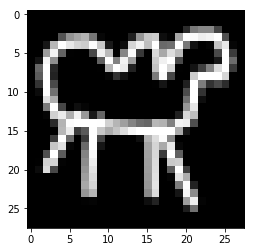

In [44]:
plt.imshow(x_train[200,:,:,0], cmap = 'gray')

In [45]:
gan = GAN(input_dim = (28,28,1)
        , discriminator_conv_filters = [64,64,128,128]
        , discriminator_conv_kernel_size = [5,5,5,5]
        , discriminator_conv_strides = [2,2,2,1]
        , discriminator_batch_norm_momentum = None
        , discriminator_activation = 'relu'
        , discriminator_dropout_rate = 0.4
        , discriminator_learning_rate = 0.0008
        , generator_initial_dense_layer_size = (7, 7, 64)
        , generator_upsample = [2,2, 1, 1]
        , generator_conv_filters = [128,64, 64,1]
        , generator_conv_kernel_size = [5,5,5,5]
        , generator_conv_strides = [1,1, 1, 1]
        , generator_batch_norm_momentum = 0.9
        , generator_activation = 'relu'
        , generator_dropout_rate = None
        , generator_learning_rate = 0.0004
        , optimiser = 'rmsprop'
        , z_dim = 100
        )

if mode == 'build':
    gan.save(RUN_FOLDER)
else:
    gan.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

In [42]:
BATCH_SIZE = 64
EPOCHS = 6000
PRINT_EVERY_N_BATCHES = 5

In [ ]:
gan.trainable=True
gan.train(     
    x_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
)

5 [D loss: (0.720)(R 0.344, F 1.095)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.361] [G acc: 1.000]
6 [D loss: (0.649)(R 0.390, F 0.908)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.345] [G acc: 1.000]
7 [D loss: (0.640)(R 0.400, F 0.880)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.334] [G acc: 1.000]
8 [D loss: (0.634)(R 0.362, F 0.906)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.336] [G acc: 1.000]
9 [D loss: (0.663)(R 0.377, F 0.949)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.352] [G acc: 1.000]
10 [D loss: (0.683)(R 0.389, F 0.977)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.402] [G acc: 1.000]
11 [D loss: (0.696)(R 0.423, F 0.969)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.467] [G acc: 1.000]
12 [D loss: (0.699)(R 0.460, F 0.938)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.523] [G acc: 1.000]
13 [D loss: (0.703)(R 0.492, F 0.913)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.583] [G acc: 1.000]
14 [D loss: (0.690)(R 0.513, F 0.868)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.623] [G acc: 1.

In [ ]:
fig = plt.figure()
plt.plot([x[0] for x in gan.d_losses], color='black', linewidth=0.25)

plt.plot([x[1] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in gan.d_losses], color='red', linewidth=0.25)
plt.plot([x[0] for x in gan.g_losses], color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.xlim(0, 2000)
plt.ylim(0, 2)

plt.show()
